In [1]:
from pyspark import SparkConf, SparkContext, SQLContext

conf = SparkConf().setAppName("test").setMaster("local")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)
print(sc)
print(sqlContext)

<SparkContext master=local appName=test>


# We increase the broadcast Timeout during model training

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").config("spark.sql.broadcastTimeout", "3600000000").getOrCreate()

In [ ]:
# We read from the s3 buckets and store it in the below datframes

In [4]:

credit_record = sqlContext.read.csv("s3://tdronitaaws/credit_record.csv", header= True, inferSchema = True)


In [5]:
credit_application = sqlContext.read.csv("s3://tdronitaaws/application_record.csv" ,header= True, inferSchema = True)

In [6]:
# We check the below shapes

def spark_shape(self):
    return(self.count(),len(self.columns))

In [7]:
import pyspark
pyspark.sql.dataframe.DataFrame.shape=spark_shape

In [8]:
# we print the shapes and dtypes also look into the head
print(credit_record.shape())
print(credit_application.shape())
print(credit_record.dtypes)
print(credit_application.dtypes)
credit_application.head()

(1048575, 3)
(438557, 18)
[('ID', 'int'), ('MONTHS_BALANCE', 'int'), ('STATUS', 'string')]
[('ID', 'int'), ('CODE_GENDER', 'string'), ('FLAG_OWN_CAR', 'string'), ('FLAG_OWN_REALTY', 'string'), ('CNT_CHILDREN', 'int'), ('AMT_INCOME_TOTAL', 'double'), ('NAME_INCOME_TYPE', 'string'), ('NAME_EDUCATION_TYPE', 'string'), ('NAME_FAMILY_STATUS', 'string'), ('NAME_HOUSING_TYPE', 'string'), ('DAYS_BIRTH', 'int'), ('DAYS_EMPLOYED', 'int'), ('FLAG_MOBIL', 'int'), ('FLAG_WORK_PHONE', 'int'), ('FLAG_PHONE', 'int'), ('FLAG_EMAIL', 'int'), ('OCCUPATION_TYPE', 'string'), ('CNT_FAM_MEMBERS', 'double')]


Row(ID=5008804, CODE_GENDER='M', FLAG_OWN_CAR='Y', FLAG_OWN_REALTY='Y', CNT_CHILDREN=0, AMT_INCOME_TOTAL=427500.0, NAME_INCOME_TYPE='Working', NAME_EDUCATION_TYPE='Higher education', NAME_FAMILY_STATUS='Civil marriage', NAME_HOUSING_TYPE='Rented apartment', DAYS_BIRTH=-12005, DAYS_EMPLOYED=-4542, FLAG_MOBIL=1, FLAG_WORK_PHONE=1, FLAG_PHONE=0, FLAG_EMAIL=0, OCCUPATION_TYPE=None, CNT_FAM_MEMBERS=2.0)

In [ ]:
#Now we do the EDA AS PER ASSIGNMENT



In [9]:
#What is the proportion of females in the applicant customer base?
from pyspark.sql.functions import countDistinct
df2=credit_application.select(countDistinct("CODE_GENDER"))
df2.show()

+---------------------------+
|count(DISTINCT CODE_GENDER)|
+---------------------------+
|                          2|
+---------------------------+



In [10]:
#WE UNDERSTAND THAT 67 PERCENT IS FEMALE AND 32 PERCENT IS MALE

import pyspark.sql.functions as F

tot = credit_application.count()
credit_application.groupby('CODE_GENDER').agg(
    (F.count('CODE_GENDER')).alias('count'),
    (F.count('CODE_GENDER') / credit_application.count()*100).alias('percentage')
).show()

+-----------+------+-----------------+
|CODE_GENDER| count|       percentage|
+-----------+------+-----------------+
|          F|294440|67.13836513839706|
|          M|144117|32.86163486160294|
+-----------+------+-----------------+



In [11]:
#BASIC EDA
import pyspark.sql.functions as F

tot = credit_application.count()
credit_application.groupby('NAME_EDUCATION_TYPE').agg(
    (F.count('NAME_EDUCATION_TYPE')).alias('count'),
    (F.count('NAME_EDUCATION_TYPE') / credit_application.count()*100).alias('percentage')
).show()

+--------------------+------+-------------------+
| NAME_EDUCATION_TYPE| count|         percentage|
+--------------------+------+-------------------+
|     Academic degree|   312|0.07114240566220582|
|   Incomplete higher| 14851|  3.386332905414804|
|Secondary / secon...|301821|  68.82138467747636|
|     Lower secondary|  4051| 0.9237111709538327|
|    Higher education|117522|   26.7974288404928|
+--------------------+------+-------------------+



In [12]:
#Is homeownership higher among male applicants or female applicants?
#WE GET TO SEE THAT FEMALE OWN MORE HOME FLAG_OWN_REALTY=Y TELLS IF SOMEONE IS OWNER OR NOT
import pyspark.sql.functions as F

df3 = credit_application.groupBy('CODE_GENDER', 'FLAG_OWN_REALTY').agg(F.count('*').alias('Frequency')).orderBy('CODE_GENDER', 'FLAG_OWN_REALTY')
df3.show()

+-----------+---------------+---------+
|CODE_GENDER|FLAG_OWN_REALTY|Frequency|
+-----------+---------------+---------+
|          F|              N|    86302|
|          F|              Y|   208138|
|          M|              N|    48181|
|          M|              Y|    95936|
+-----------+---------------+---------+



In [18]:
#Is there any correlation between the customer's income level and education level?
from pyspark.sql.functions import col,when

df4 = credit_application.withColumn("NAME_EDUCATION_TYPE_CAT", 
                                    when(col("NAME_EDUCATION_TYPE")=='Lower secondary',0)
                                    .when(col("NAME_EDUCATION_TYPE")=='Secondary / secondary special',1)
                                     .when(col("NAME_EDUCATION_TYPE")=='Incomplete higher',2)
                                   .when(col("NAME_EDUCATION_TYPE")=='Academic degree',3)
                                   .when(col("NAME_EDUCATION_TYPE")=='Higher education',4))


In [14]:

#the below output shows the corelation
from pyspark.mllib.stat import Statistics
import pandas as pd
corr_data = df4.select('AMT_INCOME_TOTAL','NAME_EDUCATION_TYPE_CAT')
col_names = corr_data.columns
features = corr_data.rdd.map(lambda row :row[0:])
corr_mat = Statistics.corr(features, method ='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index , corr_df.columns = col_names, col_names 
print(corr_df.to_string())

                         AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE_CAT
AMT_INCOME_TOTAL                 1.000000                 0.219696
NAME_EDUCATION_TYPE_CAT          0.219696                 1.000000


In [19]:
#What is the average and median salary of the applicant base?

#MEAN IS AVERAGE SALARY WHICH IS 187524
credit_application.select('AMT_INCOME_TOTAL').describe().show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|            438557|
|   mean|187524.28600950394|
| stddev|110086.85306622818|
|    min|           26100.0|
|    max|         6750000.0|
+-------+------------------+



In [20]:
#MEDIAN IS CALCULATED BELOW USING approxQuantile


credit_application.approxQuantile("AMT_INCOME_TOTAL",[0.5],0)

[160780.5]

In [22]:
 #WE MERGE THE TWO DATA FRAMES ON ID COLUMN AND CHECK THE SHAPE
new_df2 = credit_application.join(credit_record, ["ID"])
new_df2.shape()

(777715, 20)

In [23]:
# WE CREATE OUR TARGET COLUMN AS STATUS_CAT, THIS COLUMN WILL BE USED FOR TARGET IN THE WHOLE ASSIGNMENT
# STATUS = X,C,0,1 are considered as good customers and non deliquent so we transform below, good are coded as 1 and bad are 0


new_df2 = new_df2.withColumn("STATUS_CAT", 
                                    when(col("STATUS")=='X',0)
                                    .when(col("STATUS")=='C',0)
                                     .when(col("STATUS")=='0',0)
                                   .when(col("STATUS")=='1',0)
                                   .otherwise(1))


In [24]:
#Is the proportion of bad customers higher for people who own cars?
#the good customers are majority owners of car
import pyspark.sql.functions as F

df6 = new_df2.groupBy('FLAG_OWN_CAR', 'STATUS_CAT').agg(F.count('*').alias('Frequency')).orderBy('FLAG_OWN_CAR', 'STATUS_CAT')
df6.show()

+------------+----------+---------+
|FLAG_OWN_CAR|STATUS_CAT|Frequency|
+------------+----------+---------+
|           N|         0|   471655|
|           N|         1|     1700|
|           Y|         0|   303232|
|           Y|         1|     1128|
+------------+----------+---------+



In [26]:
#Is the proportion of bad customers higher for those living on rent than the rest of the population?
#we create a new columns for those living on rent and mark them with 0
#df8 shows that people living on rent are good customers
new_df2.select('NAME_HOUSING_TYPE').distinct().collect()
from pyspark.sql.functions import col,when

df7 = new_df2.withColumn("NAME_HOUSING_TYPE_CAT2", 
                                    when(col("NAME_HOUSING_TYPE")=='Rented apartment',0)
                                    .otherwise(1))
import pyspark.sql.functions as F

df8 = df7.groupBy('NAME_HOUSING_TYPE_CAT2', 'STATUS_CAT').agg(F.count('*').alias('Frequency')).orderBy('NAME_HOUSING_TYPE_CAT2', 'STATUS_CAT')
df8.show()

+----------------------+----------+---------+
|NAME_HOUSING_TYPE_CAT2|STATUS_CAT|Frequency|
+----------------------+----------+---------+
|                     0|         0|    10853|
|                     0|         1|       45|
|                     1|         0|   764034|
|                     1|         1|     2783|
+----------------------+----------+---------+



In [27]:
#Is the proportion of bad customers higher for those who are single than married customers?
#we create a new column NAME_FAMILY_STATUS_2 where married are 1 and single are 0
# We understand that married customers are more bad
new_df2.select('NAME_FAMILY_STATUS').distinct().collect()
from pyspark.sql.functions import col,when

df9 = df7.withColumn("NAME_FAMILY_STATUS_2", 
                                    when(col("NAME_FAMILY_STATUS")=='Separated',0)
                                    .when(col("NAME_FAMILY_STATUS")=='Married',1)
                                    .otherwise(2))
import pyspark.sql.functions as F

df10 = df9.groupBy('NAME_FAMILY_STATUS_2', 'STATUS_CAT').agg(F.count('*').alias('Frequency')).orderBy('NAME_FAMILY_STATUS_2', 'STATUS_CAT')
df10.show()

+--------------------+----------+---------+
|NAME_FAMILY_STATUS_2|STATUS_CAT|Frequency|
+--------------------+----------+---------+
|                   0|         0|    45084|
|                   0|         1|      171|
|                   1|         0|   544666|
|                   1|         1|     1953|
|                   2|         0|   185137|
|                   2|         1|      704|
+--------------------+----------+---------+



In [30]:
#end of eda questions

In [34]:
# more eda for logistic regression

#Count of non-null for selected columns 


from pyspark.sql.functions import col, when, count
df_Columns=["OCCUPATION_TYPE"]
new_df2.select([count(when(col(c).isNotNull(), c)).alias(c) for c in df_Columns]
   ).show()
new_df2.shape()

+---------------+
|OCCUPATION_TYPE|
+---------------+
|         537667|
+---------------+



(777715, 21)

In [36]:
# From above we see that there are many null rows so we clear that column
#So now we have one column less 
new_df2 = new_df2.drop("OCCUPATION_TYPE") 
new_df2.shape()

(777715, 20)

In [37]:
#Woe class we create
#The WOE reflects group identity, 
#which means that it captures the general trend of distribution of good and bad customers.

from pyspark.sql import DataFrame
class WOE_IV(object):
    
    """
    This class contains methods that are used for calculating the WOE and IV values in a given dataset.
    
    Attributes
    ----------
    df : spark DataFrame
        The spark dataframe
    cols_to_woe : list
        Columns that you want to convert in WOE and IV
    label_column : str
        target column of the data
    good_label : str
        Predicted variable in the form of 1 or 0
    """
    
    def __init__(self, df: DataFrame, cols_to_woe: [str], label_column: str, good_label: str):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {} # This is a dictionary which will store all the WOE and IV computed in the latter part of the code

    def fit(self):  
        """
        This method takes the columns in 'cols_to_woe' and calculates the good and bad amounts, and then assigns the WOE values in the dictionary, 'fit_data'
        """
        for col_to_woe in self.cols_to_woe: # Iterating over each column in the list, cols_to_woe
            
            total_good = self.compute_total_amount_of_good() # Computes the total amount of good labels in the entire dataset
            total_bad = self.compute_total_amount_of_bad() # Computes the total amount of bad labels in the entire dataset
            
            woe_df = self.df.select(col_to_woe) # This dataframe stores the column, col_to_woe from the DataFrame
            categories = woe_df.distinct().collect() # Creates a list of all the distinct categories in the column, col_to_woe
            for category_row in categories: # Iterating over each category in the distinct categories of the column
                category = category_row[col_to_woe]
                
                # For each category, we calculate the good_amount and bad_amount
                good_amount = self.compute_good_amount(col_to_woe, category)
                bad_amount = self.compute_bad_amount(col_to_woe, category)
                
                # If the good_amount or bad_amount is 0, we replace it with 0.5, because in the calculation of woe, it comes in the denominator resulting in a Nan value which will give an error
                good_amount = good_amount if good_amount != 0 else 0.5
                bad_amount = bad_amount if bad_amount != 0 else 0.5

                # Calculating the fraction of good_amount and bad_amount specific to that category
                good_dist = good_amount / total_good
                bad_dist = bad_amount / total_bad

                # Calling the build_fit_data method which calculates the WOE and IV for the category in the column and stores it in the dictionary, fit_data
                self.build_fit_data(col_to_woe, category, good_dist, bad_dist)

    def transform(self, df: DataFrame):
        """
        This method creates a column called "col_to_woe + '_woe'" which replaces the given category value with the WOE value.
        It finally returns a final dataframe containing the WOE values in place of the columns
        """
        def _encode_woe(col_to_woe_):
            return F.coalesce(
                *[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe']))
                  for category, woe_iv in self.fit_data[col_to_woe_].items()]
            )

        for col_to_woe, woe_info in self.fit_data.items():
            # Adds another column to the df containing the final WOE values
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
     # Computes the total amount of good labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
     # Computes the total amount of bad labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
     # Computes the total amount of good labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label)
                      ).count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        # Computes the total amount of bad labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label)
                      ).count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        """
        Calculates the WOE and value for the specific category and saves it in the woe_info dictionary which is saves in the fit_data dictionary
        
        
        Attributes:
        col_to_woe: str
        name of the feature
        
        category: str
        Class of that feature
        
        good_dist: float
        Fraction of good labels specific to that category
        
        bad_dist: float
        Fraction of bad labels specific to that category
        """
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist), # Calculating the WOE value for the category in the column
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist) # Calculating the IV value for the category in the column
            }
        }

        # Adding the feature, col_to_woe to fit_data if not present already
        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        """
        Returns the IV dictionary which contains the IV value for each feature
        """
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv'] # IV for the feature = IV value for the indiviual categories of the feature (column)
        return iv_dict

In [38]:
#creating montonus bins for continuous variables
import numpy as np
from pyspark.ml.feature import QuantileDiscretizer
import scipy.stats.stats as stats

spike_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']
max_bucket = 5 
for x in spike_cols:
    r= 0
    n= max_bucket
    while ((np.abs(r) < 1 )& (n > 1 )):
        discretizer = QuantileDiscretizer(numBuckets =n , inputCol =x , outputCol =x +"bucket")
        d1 = discretizer.fit(new_df2).transform(new_df2)
        d2 = d1.groupBy( x + "bucket").agg(F.mean(x).alias("X1"), F.mean("STATUS_CAT").alias("Y1")).orderBy("X1")
        a1 = d2.select("X1").rdd.flatMap(lambda x:x).collect()
        b1 = d2.select("Y1").rdd.flatMap(lambda x:x).collect()
        r,p =  stats.spearmanr(a1, b1)
        if(r==1):
            print(x+ "bucket")
            new_df2 = discretizer.fit(new_df2).transform(new_df2)
        n = n -1 

print(new_df2)

DAYS_EMPLOYEDbucket
DataFrame[ID: int, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: int, AMT_INCOME_TOTAL: double, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, DAYS_BIRTH: int, DAYS_EMPLOYED: int, FLAG_MOBIL: int, FLAG_WORK_PHONE: int, FLAG_PHONE: int, FLAG_EMAIL: int, CNT_FAM_MEMBERS: double, MONTHS_BALANCE: int, STATUS: string, STATUS_CAT: int, DAYS_EMPLOYEDbucket: double]


In [39]:
# calculating woe and IV for all categorical variable (including bin variables from continuous variables)

import math
cols_to_woe = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE' 
               ,'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_WORK_PHONE' ,'FLAG_PHONE',
              'FLAG_EMAIL', 'DAYS_EMPLOYEDbucket' ]


woe = WOE_IV( new_df2,cols_to_woe,'STATUS_CAT',1  )

#woe encoding
woe.fit()

encoded_df = woe.transform(new_df2)

#information value

ivs = woe.compute_iv()












In [40]:
#print woe for each variable and category

print(woe.fit_data)
print(ivs)

{'CODE_GENDER': {'F': {'woe': -0.14982463630418086, 'iv': 0.013914914896359385}, 'M': {'woe': 0.2463211337897097, 'iv': 0.02287699605624153}}, 'FLAG_OWN_CAR': {'Y': {'woe': 0.019095428216215418, 'iv': 0.00014406171382780794}, 'N': {'woe': -0.012472070822197248, 'iv': 9.409309271743701e-05}}, 'FLAG_OWN_REALTY': {'Y': {'woe': -0.01475934305545162, 'iv': 0.00014262939795350567}, 'N': {'woe': 0.027993079164006385, 'iv': 0.0002705158361741757}}, 'NAME_INCOME_TYPE': {'Student': {'woe': -0.9000826466756933, 'iv': 0.000232310184930355}, 'Commercial associate': {'woe': 0.29776362987723526, 'iv': 0.02432209706522298}, 'State servant': {'woe': -0.6454698640706565, 'iv': 0.02587365249775274}, 'Working': {'woe': -0.19675109340732444, 'iv': 0.01809298877065602}, 'Pensioner': {'woe': 0.26852545546842027, 'iv': 0.013640045182080706}}, 'NAME_EDUCATION_TYPE': {'Academic degree': {'woe': -1.8098237868128069, 'iv': 0.0016349117368392127}, 'Incomplete higher': {'woe': 0.14954741275869787, 'iv': 0.000940197

In [41]:
#writing contents to a file to get the check point
#LOADING THE DATA FROM THE SAVED FILE
encoded_df.write.format("com.databricks.spark.csv").mode('overwrite').save('encodeddf.csv', header = 'true')
encoded_df_saved = spark.read.csv("encodeddf.csv" , header = True, inferSchema =True)

print(encoded_df.shape())
print(encoded_df_saved.shape())

(777715, 33)
(777715, 33)


In [42]:
#splitting the test and train data

train , test = encoded_df_saved.randomSplit([0.7,0.3],seed =2018)
print("Training Dataset count " + str(train.count()))
print("Testing Dataset count " + str(test.count()))

Training Dataset count 544509
Testing Dataset count 233206


In [43]:
#specify feature list to be used for logistic regression
from pyspark.ml.feature import VectorAssembler
feature_list = ['CODE_GENDER_woe','FLAG_OWN_CAR_woe','FLAG_OWN_REALTY_woe',
               'FLAG_OWN_REALTY_woe','NAME_INCOME_TYPE_woe','NAME_EDUCATION_TYPE_woe',
               'NAME_FAMILY_STATUS_woe','NAME_HOUSING_TYPE_woe' ,'FLAG_MOBIL_woe' ,'FLAG_WORK_PHONE_woe',
               'FLAG_PHONE_woe' , 'FLAG_EMAIL_woe'  , 'DAYS_EMPLOYEDbucket_woe' ]

#Creating feature vector with all inputing columns

assembler = VectorAssembler(inputCols = feature_list , outputCol ="features")

train = assembler.transform(train)

test = assembler.transform(test)



In [44]:
assembler

VectorAssembler_1a554e55f6e1

In [45]:
type(train) 

pyspark.sql.dataframe.DataFrame

In [46]:
#Building Logistic Regression and predicting test and train on same dataset
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol ="STATUS_CAT" , featuresCol = "features")
model = lr.fit(train)

In [47]:
# We check the probabibility in test 

predict_train = model.transform(train)
predict_test = model.transform(test)
predict_test.select("STATUS_CAT","prediction","probability").show(truncate=False)




+----------+----------+------------------------------------------+
|STATUS_CAT|prediction|probability                               |
+----------+----------+------------------------------------------+
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |
|0         |0.0       |[0.9948205703162398,0.00517942968376017

In [48]:
#creating a target probability column  for STATUS_CAT probability
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
secondelement = udf(lambda v:float(v[1]), FloatType())
predict_train = predict_train.withColumn('prob_int', secondelement('probability'))
predict_test = predict_test.withColumn('prob_int', secondelement('probability'))
predict_test.select("STATUS_CAT","prediction","probability",'prob_int').show(truncate=False)



+----------+----------+------------------------------------------+------------+
|STATUS_CAT|prediction|probability                               |prob_int    |
+----------+----------+------------------------------------------+------------+
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.9971805662104959,0.002819433789504111] |0.0028194338|
|0         |0.0       |[0.99718056621049

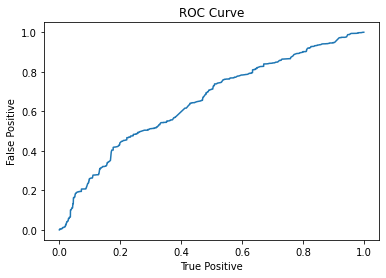

Training Set areaunderROc:0.651064343077641


In [49]:
#AUC ROC for training data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_curve

training_summary = model.summary
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive')
plt.xlabel('True Positive')
plt.title('ROC Curve')
plt.show()
print('Training Set areaunderROc:' + str(training_summary.areaUnderROC))


#AUC ROC for test data

preds = predict_test.select('STATUS_CAT','prob_int' ).rdd.map(lambda row: (float(row['prob_int']),
                                                                       float(row['STATUS_CAT'] ))).collect()

lr_probs , y_test = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs , pos_label =1 )

ns_probs = [0 for _ in range (len(y_test))]

















In [50]:
#calculate scores
from sklearn.metrics import roc_auc_score
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [51]:
# summarize scores

print('TestingSet areaunderROc=%.3f '%(lr_auc))

TestingSet areaunderROc=0.679 


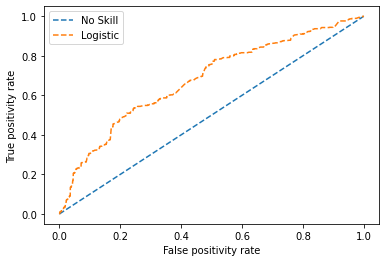

In [52]:
#calculate roc curves 

ns_fpr , ns_tpr , _ = roc_curve(y_test , ns_probs)
lr_fpr , lr_tpr , _ = roc_curve(y_test , lr_probs)

#plot the curve for the model
plt.plot(ns_fpr , ns_tpr, linestyle ='--' , label = 'No Skill')
plt.plot(lr_fpr , lr_tpr, linestyle ='--' , label = 'Logistic')

#axis labels

plt.xlabel('False positivity rate')
plt.ylabel('True positivity rate')

#show legend

plt.legend()
#show plot

plt.show()

In [53]:
#calculating KS

#CREATING DECILES USING THE PREDICTED PROBABILITY COLUMN

discretizer = QuantileDiscretizer(numBuckets =10 , inputCol ='prob_int', outputCol = 'PROB_BUCKET')
predict_train = discretizer.fit(predict_train).transform(predict_train)
predict_test = discretizer.fit(predict_test).transform(predict_test)


In [54]:
# Creating good and bad for each decile
ks_train =predict_train.groupBy('PROB_BUCKET').agg(F.count("ID").alias("Total"),
                                                   F.max("prob_int").alias("max_prob"),
                                                  F.min("prob_int").alias("min_prob"),
                                                  F.sum("STATUS_CAT").alias("bads"),
                                                  F.count(F.when (col("STATUS_CAT")==0,0)).alias("goods"))

ks_test =predict_test.groupBy('PROB_BUCKET').agg(F.count("ID").alias("Total"),
                                                   F.max("prob_int").alias("max_prob"),
                                                  F.min("prob_int").alias("min_prob"),
                                                  F.sum("STATUS_CAT").alias("bads"),
                                                  F.count(F.when (col("STATUS_CAT")==0,0)).alias("goods"))


from pyspark.sql.window import Window
ks_train = ks_train.withColumn('%cumuBad', F.sum('bads').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 
               1))/F.sum('bads').over(Window.partitionBy()))                                                                                                 
                                        

ks_train = ks_train.withColumn('%cumuGood', F.sum('goods').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 
              1))/F.sum('goods').over(Window.partitionBy()))  

ks_train = ks_train.withColumn('%diff', F.col('%cumuBad') - F.col('%cumuGood'))

ks_train = ks_train.withColumn('max_diff', F.when(F.col('%diff') == F.max('%diff').over(Window.partitionBy()), '<---').otherwise(' '))
         
ks_test = ks_test.withColumn('%cumuBad', F.sum('bads').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 
              1))/F.sum('bads').over(Window.partitionBy()))                                                                                                 
                                        
ks_test = ks_test.withColumn('%cumuGood', F.sum('goods').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 
               1))/F.sum('goods').over(Window.partitionBy()))  

ks_test = ks_test.withColumn('%diff', F.col('%cumuBad') - F.col('%cumuGood'))

ks_test = ks_test.withColumn('max_diff', F.when(F.col('%diff') == F.max('%diff').over(Window.partitionBy()), '<---').otherwise(' '))
           
    

In [55]:
ks_test.sort(col('PROB_BUCKET').desc()).show()
ks_train.sort(col('PROB_BUCKET').desc()).show()

+-----------+-----+------------+------------+----+-----+------------------+-------------------+-------------------+--------+
|PROB_BUCKET|Total|    max_prob|    min_prob|bads|goods|          %cumuBad|          %cumuGood|              %diff|max_diff|
+-----------+-----+------------+------------+----+-----+------------------+-------------------+-------------------+--------+
|        9.0|23602|  0.02814461|0.0060409773| 257|23345|0.4880952380952381|0.20328705576547343| 0.2848081823297647|    <---|
|        8.0|24045| 0.006040113|0.0049924334| 153|23892|0.5535714285714286| 0.3003924842705043| 0.2531789443009243|        |
|        7.0|22619|0.0049854508| 0.004281541|  55|22564|0.6571428571428571|0.41183305647125656|0.24530980067160058|        |
|        6.0|25982|  0.00428064|0.0037586049|  87|25895|0.7583333333333333|0.49993544666603545|0.25839788666729785|        |
|        5.0|20557|0.0037562957|0.0033549112|  85|20472|0.8154761904761905| 0.5996660440856235|0.21581014639056695|        |


In [56]:
min_prob_max_ks = ks_test.where(col("max_diff" )== '<---').select(col("min_prob")).collect()[0]
predict_test = predict_test.withColumn('pred_class', F.when(F.col('prob_int')> round(min_prob_max_ks[0],4),1).otherwise(0))

In [57]:
predict_test.groupBy('pred_class','STATUS_CAT').count().show()

+----------+----------+------+
|pred_class|STATUS_CAT| count|
+----------+----------+------+
|         1|         0| 24000|
|         1|         1|   258|
|         0|         0|208366|
|         0|         1|   582|
+----------+----------+------+



In [58]:
#GENERATE EVALUATION METRICS
from pyspark.sql.types import DoubleType

results = predict_test.select(['pred_class','STATUS_CAT'])
results = results.withColumn("STATUS_CAT" , results["STATUS_CAT"].cast(DoubleType()))
results = results.withColumn("pred_class", results["pred_class"].cast(DoubleType()))
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
predictionAndLabels = results.rdd
metrics = MulticlassMetrics(predictionAndLabels)
metrics1 = BinaryClassificationMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
print(cm)
#Overall Statitistics

precision = metrics.precision(1)
recall = metrics.recall(1)
f1Score =  2 * (precision * recall) / (precision + recall)

print("SummaryStats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("f1Score = %s" % f1Score)

#Area under precision recall curve
print("Area under PR = %s" % metrics1.areaUnderPR)

#Area under ROC curve
print("Area under ROC = %s" % metrics1.areaUnderROC)

[[208366.  24000.]
 [   582.    258.]]
SummaryStats
Precision = 0.010635666584219638
Recall = 0.30714285714285716
f1Score = 0.020559407124073628
Area under PR = 0.008198991615681186
Area under ROC = 0.6019287613998113
